# Servidor de mapas

En este colab vamos a aprender cómo utilizar el servidor de mapas para cargar el mapa de nuestro entorno una vez ha sido escaneado.

En primer lugar vamos a crear un nuevo paquete que llameremos provide_map. Este paquete contendrá el fichero de lanzamiento necesario para lanzar el servidor de mapas, con la finalidad de hacer una llamada a este servidor y cargar nuestro mapa.


In [ ]:
cd $HOME/turtlebot3_ws/src
ros2 pkg create --build-type ament_python provide_map

A continuación, creamos tres directorios:

- map: incluir en este directorio los ficheros my_map.yaml y my_map.pgm que hemos creado en el colab anterior (en el paquete my_slam)

- rviz: incluir en este directorio el fichero de configuración my_slam.rviz que hemos creado en el colab anterior (en el paquete my_slam)

- launch: introducimos el script **provide_map.launch.py**.

In [ ]:
cd turtlebot3_ws/src/provide_map
mkdir launch
mkdir map
mkdir rviz

In [ ]:
# provide_map.launch.py
import os

import launch.actions
import launch_ros.actions
from ament_index_python.packages import get_package_share_directory
from launch import LaunchDescription
from launch_ros.actions import Node

def generate_launch_description():
    
    rviz_config_dir = os.path.join(get_package_share_directory('provide_map'), 'rviz', 'my_slam.rviz')
    map_file = os.path.join(get_package_share_directory('provide_map'), 'map', 'my_map.yaml')

    return LaunchDescription([
        Node(
            package='nav2_map_server',
            node_executable='map_server',
            node_name='map_server',
            output='screen',
            parameters=[{'use_sim_time': True}, 
                        {'yaml_filename':map_file} 
                       ]),

        Node(
            package='rviz2',
            node_executable='rviz2',
            node_name='rviz2',
            arguments=['-d', rviz_config_dir],
            parameters=[{'use_sim_time': True}],
            output='screen'
            ),

        Node(
            package='nav2_lifecycle_manager',
            node_executable='lifecycle_manager',
            node_name='lifecycle_manager_localization',
            output='screen',
            parameters=[{'use_sim_time': True},
                        {'autostart': True},
                        {'node_names': ['map_server']}])            
        ])

Este fichero lanza tres nodos:
- nav2_map_server: contiene un servidor que se encargará de proporcionarnos el mapa. Este servidor queda abierto, a la espera de recibir una petición de carga del mapa. Para ello utilzará la llamada al servicio map_server/load_map

- rviz2: lanza el visualizador RVIZ con la configuración que hemos guardado en el directorio rviz

- nav2_lifecycle_manager: se trata de un nodo que se encarga de controlar el ciclo de vida de los nodos ROS2. Lanza una máquina de estados que decidirá en qué estado se encuentra cada nodo (unconfigured, inactive, active o finalized). Para saber más acerca de este tema podéis acceder a la siguiente[ web](https://design.ros2.org/articles/node_lifecycle.html). Este manejador del ciclo de vida de los nodos permite que el sistema tenga un comportamiento determinístico y facilita la depuración del mismo.

Editar el fichero setup.py e incluir el código necesario para que se instalen todos los archivos de configuración que necesitamos.

In [ ]:
from setuptools import setup
import os #incluir
from glob import glob #incluir

package_name = 'provide_map_01'

setup(
    name=package_name,
    version='0.0.0',
    packages=[package_name],
    data_files=[
        ('share/ament_index/resource_index/packages',
            ['resource/' + package_name]),
        ('share/' + package_name, ['package.xml']),
        (os.path.join('share', package_name, 'map'), glob('map/*.pgm')),#incluir
        (os.path.join('share', package_name, 'map'), glob('map/*.yaml')),#incluir
        (os.path.join('share', package_name, 'rviz'), glob('rviz/*.rviz')),#incluir
        (os.path.join('share', package_name, 'launch'), glob('launch/*.launch.py')),#incluir
    ],
    install_requires=['setuptools'],
    zip_safe=True,
    maintainer='asun',
    maintainer_email='asun@todo.todo',
    description='TODO: Package description',
    license='TODO: License declaration',
    tests_require=['pytest'],
    entry_points={
        'console_scripts': [
        ],
    },
)


Compilamos el paquete:

In [ ]:
cd $HOME/turtlebot3_ws
colcon build --packages-select provide_map

Ejecutamos el fichero de lanzamiento.

In [ ]:
ros2 launch provide_map provide_map.launch.py

Al hacerlo se abrirá el visualizador RVIZ, pero todavía no tenemos el mapa cargado. 

Podéis revisar qué servicios tenemos abiertos en este momento, veréis que existen varios servicios relacionados con /map_server.

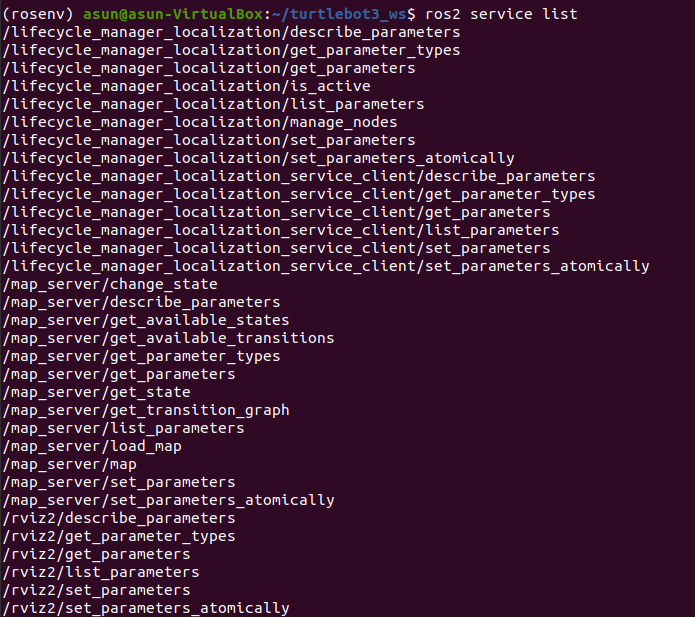

Si necesitáis más información acerca de los servicios proporcionados por el nodo map_server podéis utilizar el comando:


```
ros2 node info /map_server
```

Obtendréis la siguiente información:
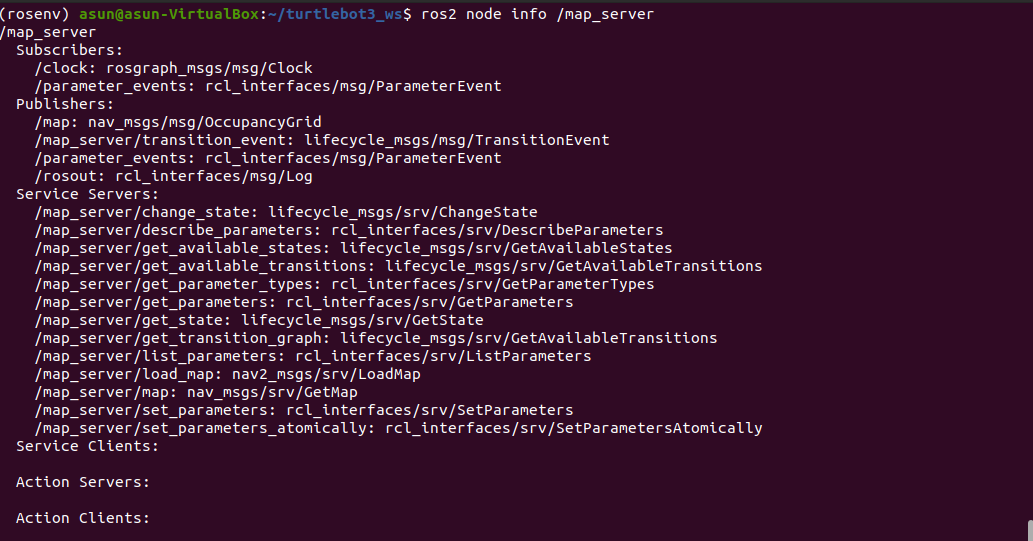


Utilizamos el servicio map_server/load_map para cargar el mapa del entorno. Podemos hacer la llamada al servidor del servicio de la siguiente manera:

In [ ]:
ros2 service call /map_server/load_map nav2_msgs/srv/LoadMap "{map_url: $HOME/turtlebot3_ws/src/provide_map/map/my_map.yaml}"

Ahora debería aparecer el mapa en el visualizador RVIZ.

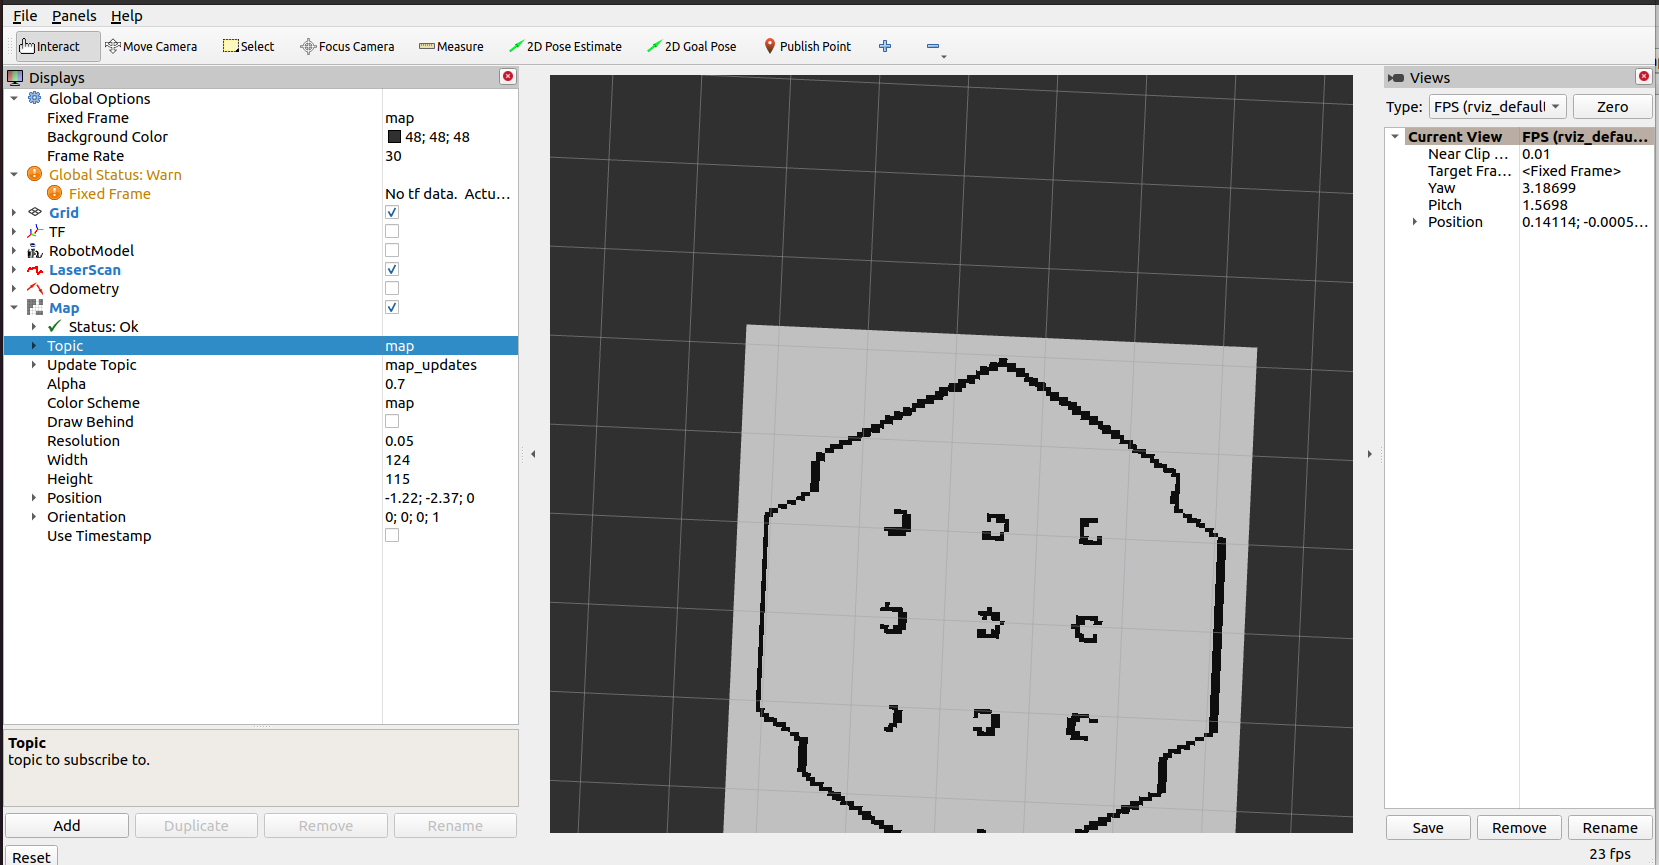

Esta misma llamada al servicio podremos realizarla desde un script de python, tal y como vimos en el colab [ROS2_A09 Servicios](https://colab.research.google.com/drive/1SMMXHjgHk1v-ejmUlRC9FcAbwtNHuux4?usp=sharing).

# Conclusión

En este colab hemos aprendido a:

- Abrir el servidor de mapas

- Cargar el mapa de un entorno previamente escaneado